# Projekt 1 Milestone 2 - Feature engineering
## Autorzy: Katarzyna Solawa, Jan Smoleń

In [14]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
import random
from sklearn import manifold
import xgboost as xgb
random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from matplotlib import pyplot 

In [15]:
df=pd.read_csv("congressional_voting_dataset.csv")

### Encoding
W naszych danych kodowanie zmiennych kategorycznych wydaje się raczej proste. Głosy na nie oznaczamy jako 0, brak głosu  jako 0.5, a głosy na tak to 1. Podobnie intuicyjnie republikanów oznaczamy jako zera, a demokratów jako jedynki.

In [16]:
df=df.replace("n", 0)
df=df.replace("y", 1)
df=df.replace("?",  0.5)  
df=df.replace("republican", 0)
df=df.replace("democrat",  1)


### Row reduction
Na początku usuniemy powtarzające się rzędy. Ze względu na kategoryczne wartości w naszych danych, nie widzimy tu outlierów w postaci rzędów, które się szczególnie wyróżniają jedną wartością. Jedyny rząd, który odrzucimy to ten, w którym wartości wszystkich głosowań wynosiły "?" - jest to prawdopodobnie brak danych, bądź dany reprezentant z jakiś osobliwych powodów nie wziął udziału w żadnym głosowaniu. 

In [17]:
df=df.drop_duplicates()
X=df.drop(["political_party"], axis=1)

indexes=[]
colnames=X.columns
for i in range(len(X)):
    for j in range(len(colnames)):
        if X.iloc[i, j]!=0.5:
            break
        if j==len(colnames)-1:
            indexes.append(i)
X=X.drop(indexes[0], axis=0)
y=df["political_party"].drop(indexes[0], axis=0)

### Feature Selection
W celu wyboru cech do modelu spojrzymy najpierw ponownie na macierz korelacji. (Nie wiedzieliśmy, że feature selection będzie tematem następnym zajęć - robiliśmy to intuicyjnie, używając znanych nam narzedzi.)


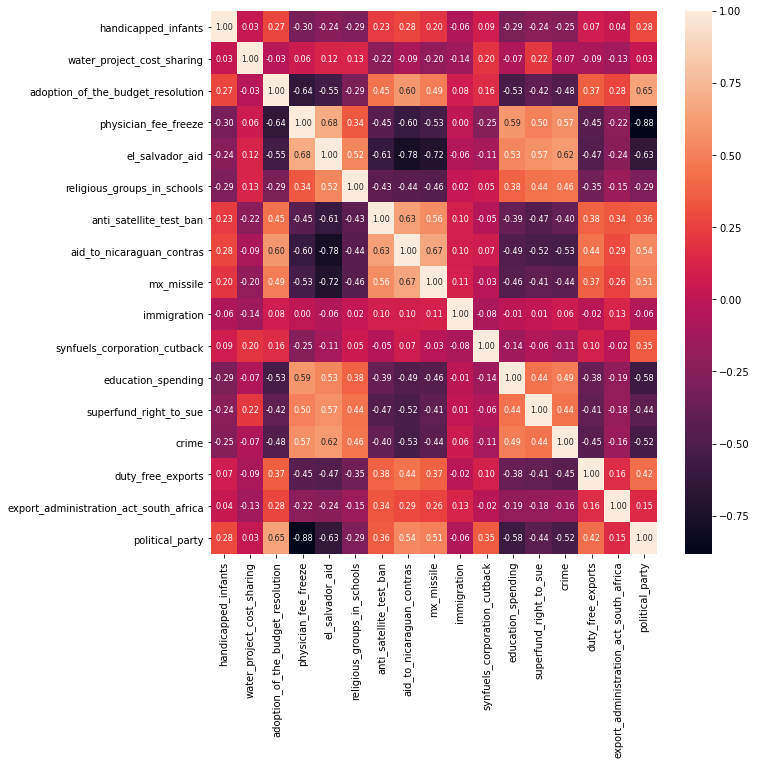

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 8}, fmt='.2f')
plt.show()

Usuniemy dwie zmienne, które w porównaniu z innymi są bardzo mało skorelowane z naszym celem - `water_project_cost_sharing` i `immigration`. Spróbujemy też usunąć zmienną `el_salvador_aid` - mimo, że jest silnie związana z celem, jest także najbardziej skorelowana z innymi zmiennymi objaśniającymi.

In [19]:
drop=["water_project_cost_sharing", "immigration", "el_salvador_aid"]
X=X.drop(drop, axis=1)

Naszym modelem bazowym, którego dziś użyjemy, będzie xgboost bez tuningu hiperparametrów.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [21]:
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")

Accuracy: 94.20289855072464%


Jak widzimy, nasz model całkiem dobrze sobie radzi z przewidywaniem przynależności do danej partii politycznej - osiąga ponad 96% skuteczności. Teraz spojrzymy, jak ważne dla niego są poszczególne kolumny - użyjemy do tego wbudowanej funkcji modelu xgb. 

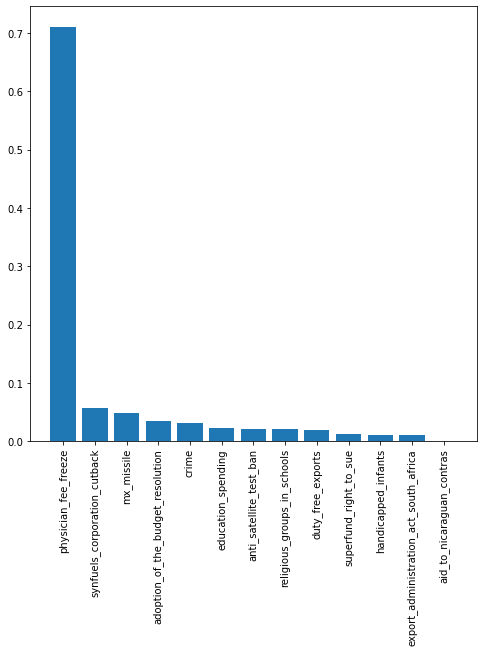

In [22]:
df1 = pd.DataFrame({'col' : X.columns , 'y' : xgb_model.feature_importances_})
df1 = df1.sort_values(by="y", ascending=False)
plt.figure(figsize=(8,8))
pyplot.bar(df1.col, df1.y)
plt.xticks(rotation=90)
pyplot.show()

In [23]:
fts=["physician_fee_freeze"]
X2=X[fts]
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size = 0.2, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")

Accuracy: 94.20289855072464%


Zgodnie z oczekiwaniami wynikającymi z mapy korelacji, zmienna `physicican_fee_freeze` ma olbrzymi wpływ na predykcje naszego modelu. Na samej jej podstawie nasz model jest w stanie osiągnąć dokładność ponad 94%. Spójrzmy jeszcze, jak wyglądała by skuteczność modelu, gdybyśy wybrali jedynie 5 najważniejszych wg wykresu cech.

In [24]:
fts=["physician_fee_freeze", "mx_missile", "synfuels_corporation_cutback", "religious_groups_in_schools", "adoption_of_the_budget_resolution"]
X1=X[fts]
X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify=y, test_size = 0.2, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")


Accuracy: 94.20289855072464%


Spróbujmy jeszcze bardziej ograniczyć liczbę zmiennych

Oprócz `physician_fee_freeze` weźmy też `adoption_of_the_budget_resolution`(druga najwyższa korealacja) i `synfuels_corporation_cutback`( top 3 według feature importance, brak dużej korelacji ze zmiennymi i targetem?)


In [25]:

fts=["physician_fee_freeze","synfuels_corporation_cutback", "adoption_of_the_budget_resolution"]
X2=X[fts]
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size = 0.2, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")

Accuracy: 95.65217391304348%


Daje taki sam wyniki jak przy wybraniu top 5 słupków

Spróbujmy dodać jeszcze jedną kolumnę

In [26]:
fts=["physician_fee_freeze","synfuels_corporation_cutback", "adoption_of_the_budget_resolution", "education_spending"]
X2=X[fts]
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size = 0.2, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")

Accuracy: 94.20289855072464%


Dla `physician_fee_freeze`,`synfuels_corporation_cutback`, `adoption_of_the_budget_resolution`, `education_spending` osiągneliśmy takie same accuracy jak otrzymane dla modelu z 13 zmiennych(bez `water_project_cost_sharing`, `immigration`, `el_salvador_aid`). Nasze próby tutaj pokazują że możemy osiągnąć dobre accuracy używając niewielkiej ilości zmiennych,  te konkretne wartości zależą już oczywiście też losowych czynników.